RMSE: 2.30, MAE: 1.00, R²: 0.80


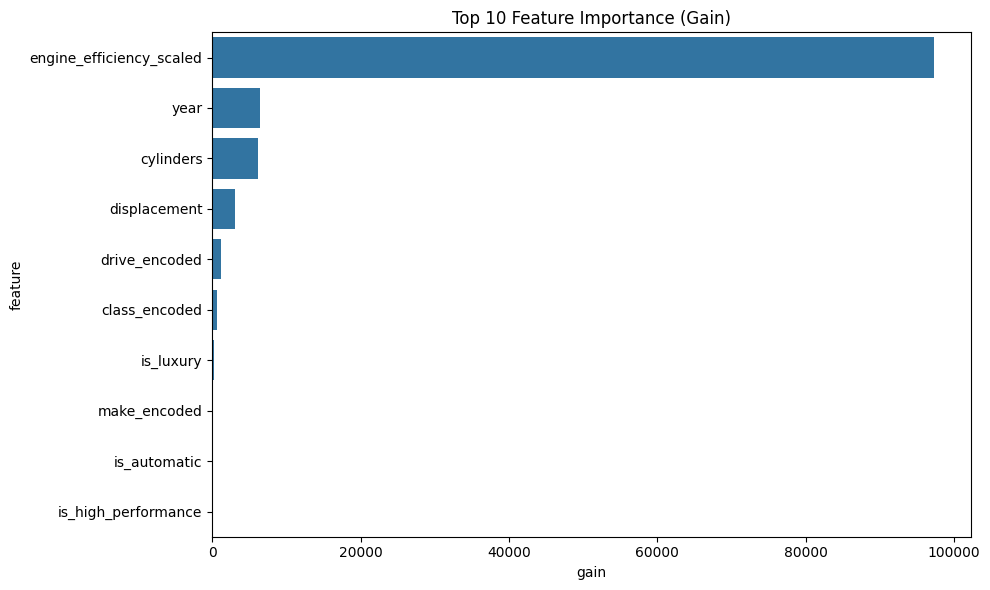

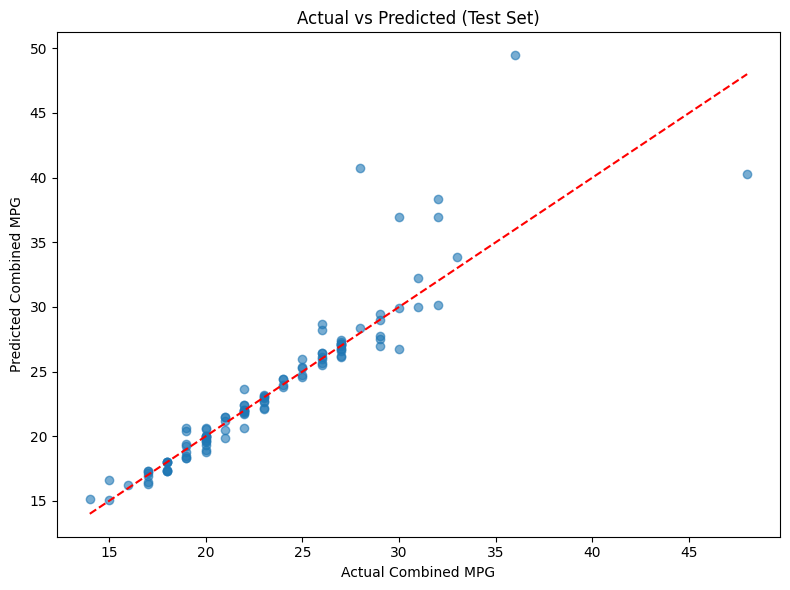

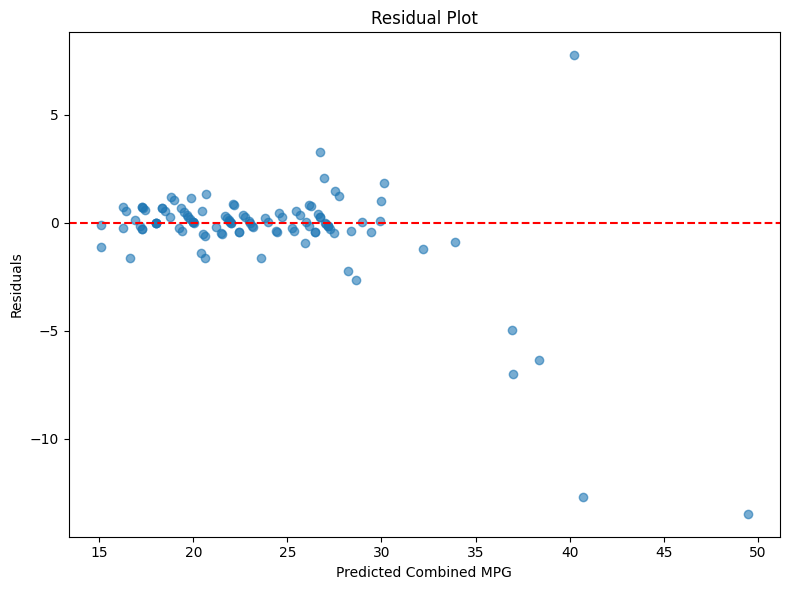

Train Score:  0.7905164659935744
Test Score:  0.7961884654439064


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from io import StringIO


df = pd.read_csv("Car Data P.csv")

# Define target
target = 'combination_mpg'

# Columns to drop (target-related or redundant)
drop_cols = [
    'city_mpg', 'highway_mpg', 'combination_mpg_scaled', 'city_mpg_scaled', 'highway_mpg_scaled',
    'mpg_diff', 'engine_efficiency', 'engine_power_density', 'fuel_efficiency_category',
    'make', 'model', 'class', 'drive', 'fuel_type', 'transmission', 'size_category', 'drivetrain_type',
    'year_scaled', 'vehicle_age_scaled', 'cylinders_scaled', 'displacement_scaled'
]

# Keep only relevant columns
feature_cols = [col for col in df.columns if col not in drop_cols and col != target]
X = df[feature_cols]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features (cylinders, displacement, year, vehicle_age)
num_cols = ['cylinders', 'displacement', 'year', 'vehicle_age']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Define categorical features (all encoded as integers)
cat_cols = [
    'make_encoded', 'class_encoded', 'drive_encoded', 'fuel_type_encoded',
    'transmission_encoded', 'size_category_encoded', 'drivetrain_type_encoded'
]

# Train LightGBM
model = LGBMRegressor(random_state=42, verbose=-1)
model.fit(X_train, y_train, categorical_feature=cat_cols)

# Predict
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'gain': model.booster_.feature_importance(importance_type='gain')
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance.head(10), x='gain', y='feature')
plt.title('Top 10 Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Combined MPG')
plt.ylabel('Predicted Combined MPG')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Combined MPG')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

Train_Score = model.score(X_train, y_train)
Test_Score = model.score(X_test, y_test)

print("Train Score: ", Train_Score)
print("Test Score: ", Test_Score)
